This notebook is used to create a model that predicts the income an adult may make.

1. Import libraries

In [10]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

2. Load data

In [35]:
column_names = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income'
]

# Load training data
train = pd.read_csv("train.csv", names=column_names, sep=',\s*', engine='python')

# Load test data
test = pd.read_csv("test.csv", names=column_names, skiprows=1, sep=',\s*', engine='python')

# Check the first few rows
print(train.head())

# Check class distribution in the training set
print(train['income'].value_counts())



   age         workclass  fnlwgt  education  education-num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   
4   28           Private  338409  Bachelors             13   

       marital-status         occupation   relationship   race     sex  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4  Married-civ-spouse     Prof-specialty           Wife  Black  Female   

   capital-gain  capital-loss  hours-per-week native-country income  
0          2174             0              40  United-States  <=50K  
1             0             0             

3. Clean data, one-hot encoding is also used since the data has many categories and is non-ordinal

In [12]:
# Define the target column
test['income'] = test['income'].str.replace('.', '', regex=False)
train['income'] = train['income'].str.replace('.', '', regex=False)

# Replace '?' with np.nan
train.replace('?', np.nan, inplace=True)
test.replace('?', np.nan, inplace=True)
train.dropna(inplace=True)
test.dropna(inplace=True)

target_col = 'income'
# Identify categorical and numerical columns
categorical_cols = train.select_dtypes(include=['object']).columns.drop(target_col)
numerical_cols = train.select_dtypes(include=['int64', 'float64']).columns

# Pipelines for both types
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_cols),
        ('cat', categorical_pipeline, categorical_cols)
    ])

4. Prepare data to be trained on and run model

In [13]:
# Define the target column
target_col = 'income'
# Encode the target variable
label_encoder = LabelEncoder()
train[target_col] = label_encoder.fit_transform(train[target_col])
test[target_col] = label_encoder.transform(test[target_col])
# Create the model pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])
# Fit the model
model_pipeline.fit(train.drop(columns=[target_col]), train[target_col])
# Make predictions on the test set
predictions = model_pipeline.predict(test.drop(columns=[target_col]))
# Evaluate the model
print(classification_report(test[target_col], predictions, target_names=label_encoder.classes_))



              precision    recall  f1-score   support

       <=50K       0.88      0.92      0.90     11360
        >50K       0.72      0.62      0.66      3700

    accuracy                           0.85     15060
   macro avg       0.80      0.77      0.78     15060
weighted avg       0.84      0.85      0.84     15060



The Random Forest classifier achieved an overall accuracy of 85%, with strong performance on the majority class (<=50K). However, its performance on the minority class (>50K) is notably weaker, with a lower recall of 62%, indicating that a significant portion of high-income individuals are misclassified. 

This may be due to the imbalance between both classes (22654 to 7508) which is not a severe imbalance so balancing the class through methods such as SMOTE is not not essential  but it might allow the model to not predict the majority class as often and improve the f1-score.  

5. Feature Importance

<Axes: title={'center': 'Top Feature Importances'}, ylabel='feature'>

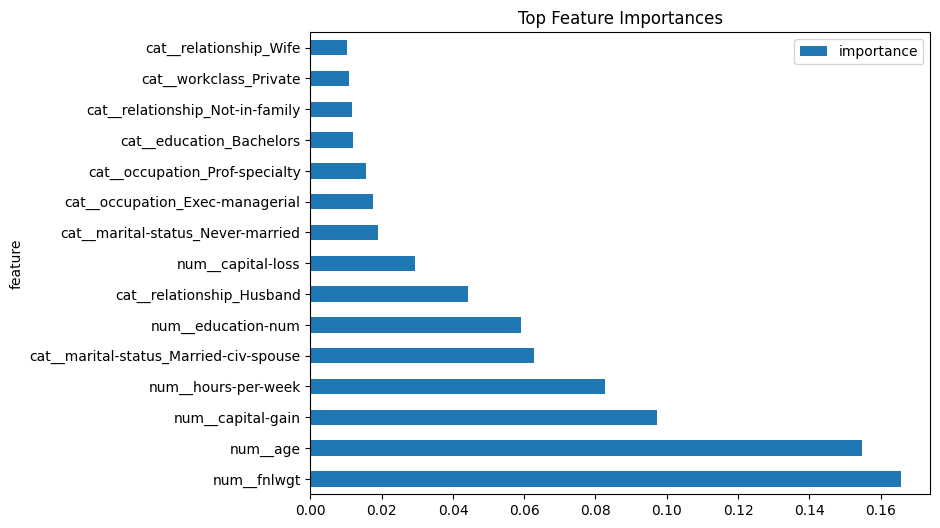

In [33]:
importances = model_pipeline.named_steps['classifier'].feature_importances_
feature_names = model_pipeline.named_steps['preprocessor'].get_feature_names_out()
importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
importance_df.sort_values('importance', ascending=False).head(15).plot(
    x='feature', y='importance', kind='barh', figsize=(8, 6), title='Top Feature Importances')


From here we can see that final weight holds the most importance to the model, it is assigned to each person to tell them how much of the full population they represent. This allows the model to predict on population level outcomes. Other important features were age, capital gain and hours per week. Older people that work more hours are more likely to have a higher level of income which was picked up by the model.

6. We can add some graphs to give a better statistical summary of the data that was trained on

C:\Users\arifu\AppData\Local\Temp\ipykernel_3540\1332141553.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='income_label', data=train, palette='viridis')


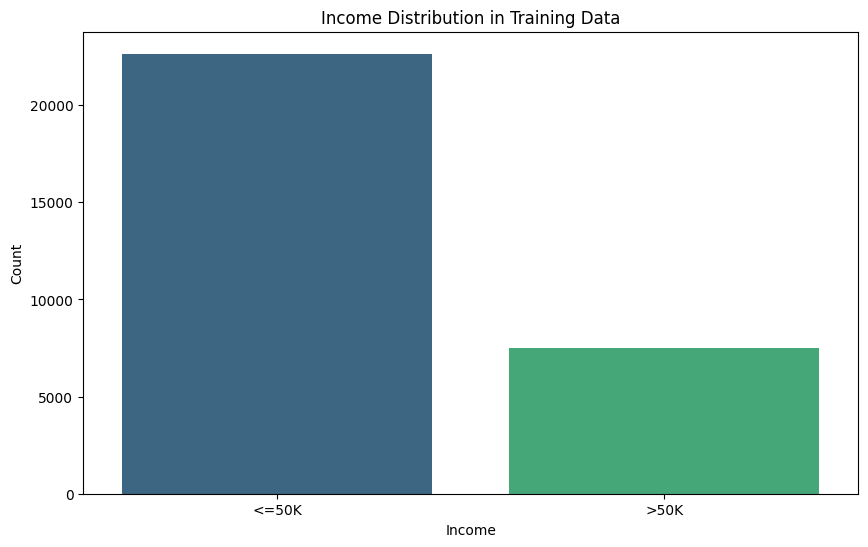

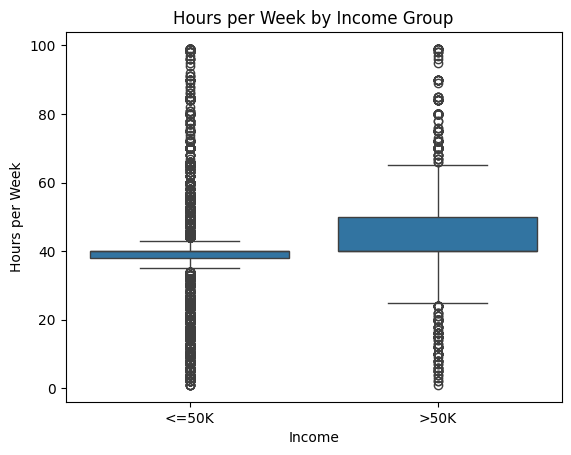

C:\Users\arifu\AppData\Local\Temp\ipykernel_3540\1332141553.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='income_label', y='age', data=train, alpha=0.5, palette='viridis')


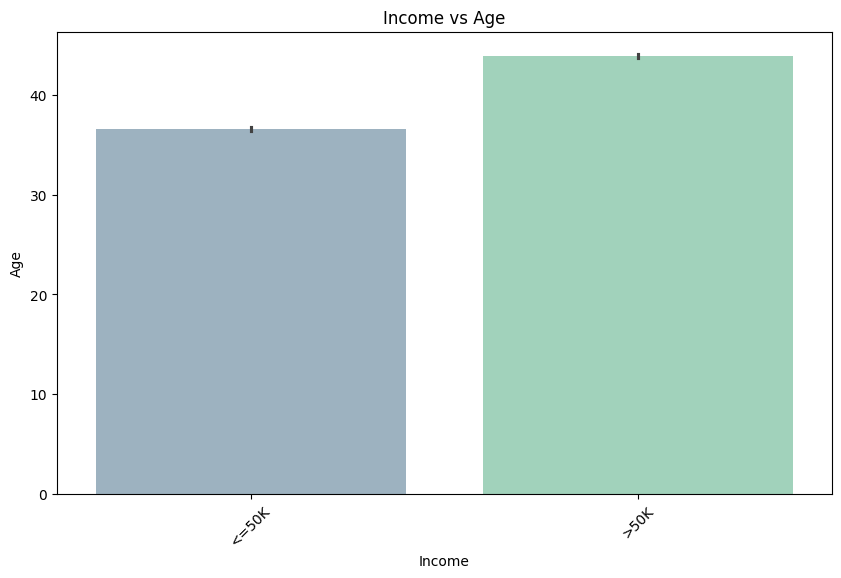

In [ ]:
# Reverse the label encoding for plotting
train['income_label'] = label_encoder.inverse_transform(train['income'])

# plot income distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='income_label', data=train, palette='viridis')
plt.title('Income Distribution in Training Data')
plt.xlabel('Income')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# plot income and hours per week
sns.boxplot(x='income_label', y='hours-per-week', data=train)
plt.title("Hours per Week by Income Group")
plt.xlabel("Income")
plt.ylabel("Hours per Week")
plt.show()

# plot income vs age
plt.figure(figsize=(10, 6))
sns.barplot(x='income_label', y='age', data=train, alpha=0.5, palette='viridis')
plt.title('Income vs Age')  
plt.xlabel('Income')
plt.ylabel('Age')
plt.xticks(rotation=45)
plt.show()

The income distribution graph better signifies the imbalance in the two classes, the other two graphs of hours per week and age show why they are so important to the model. The median hours of someone of higher earning is greater than someone who earns less. Also, the ages of those who earn more than 50k are generally higher than those who do not.